# Classifying Facial Expressions
## Author: Ahria Dominguez
### Last Updated: 8/10/2024

In this project, we will examine data from a Kaggle dataset titled _FER-2013_ (https://www.kaggle.com/datasets/msambare/fer2013). We will determine if images of facial expressions can be classified into one of seven different emotional categories using convolutional neural networks (CNNs).

The data used in these models consist of:
- Original, non-cleaned data:
    - Training Images
        - Angry: 3995
        - Disgust: 436
        - Fear: 4097
        - Happy: 7215
        - Neutral: 4965
        - Sad: 4830
        - Surprise: 3171
    - Testing Images
        - Angry: 958
        - Disgust: 111
        - Fear: 1024
        - Happy: 1774
        - Neutral: 1233
        - Sad: 1247
        - Surprise:831 
- Cleaned data (all non-facial expression photos were removed):
    - Training Images
        - Angry: 3981
        - Disgust: 435
        - Fear: 4089
        - Happy: 7203
        - Neutral: 4952
        - Sad: 4822
        - Surprise: 3163 
    - Testing Images
        - Angry: 956
        - Disgust: 111
        - Fear: 1023
        - Happy: 1772
        - Neutral: 1228
        - Sad: 1245
        - Surprise: 829 

##### Import Libraries

In [1]:
# Imports the necessary libraries to process, work with, classify the images,
# and plot results.
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, \
                                    BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

##### Running Models on the Original Dataset

###### Model 1

In order to compare how cleaning the dataset impacts the results of the model, I have to run the models on the original, untouched dataset.

In [2]:
# Sets variables to the name of the folder the data is saved to.
orig_training = 'train_original'
orig_testing = 'test_original'

In [3]:
# Initializes the training image data generator and
# rescales the images by dividing the pixels by 255.
train_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# orig_training directory.
train_generator = train_datagenerator.flow_from_directory(
    orig_training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# orig_testing directory.
test_generator = test_datagenerator.flow_from_directory(
    orig_testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# The CNN model of 'Sequential' allows for us to add layers to the model
# one at a time. This initializes the model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

2024-08-09 19:57:04.140901: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-09 19:57:04.140922: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-09 19:57:04.140927: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-09 19:57:04.140963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-09 19:57:04.140979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Gets the model ready for use with the photos, using the Adam optimizer (a good
# optimizer to adjust the learning rate during training), categorical crossentropy
# (good for multi-class classification problems), and the accuracy metric (to 
# evaluate how well the model does). 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [6]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
  1/897 [..............................] - ETA: 6:13 - loss: 1.9528 - accuracy: 0.1875

2024-08-09 19:57:04.568480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


897/897 [==============================] - 12s 13ms/step - loss: 1.7368 - accuracy: 0.2957 - val_loss: 1.5786 - val_accuracy: 0.3948
Epoch 2/50
897/897 [==============================] - 11s 12ms/step - loss: 1.5256 - accuracy: 0.4137 - val_loss: 1.4164 - val_accuracy: 0.4595
Epoch 3/50
897/897 [==============================] - 11s 12ms/step - loss: 1.4149 - accuracy: 0.4649 - val_loss: 1.3370 - val_accuracy: 0.4948
Epoch 4/50
897/897 [==============================] - 11s 12ms/step - loss: 1.3697 - accuracy: 0.4812 - val_loss: 1.3059 - val_accuracy: 0.5098
Epoch 5/50
897/897 [==============================] - 11s 12ms/step - loss: 1.3441 - accuracy: 0.4978 - val_loss: 1.2894 - val_accuracy: 0.5071
Epoch 6/50
897/897 [==============================] - 11s 12ms/step - loss: 1.3384 - accuracy: 0.4996 - val_loss: 1.3225 - val_accuracy: 0.4919
Epoch 7/50
897/897 [==============================] - 11s 12ms/step - loss: 1.3445 - accuracy: 0.5057 - val_loss: 1.2723 - val_accuracy: 0.5215
Epo

In [7]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

225/225 [==============================] - 1s 6ms/step - loss: 59.7490 - accuracy: 0.4377


[59.748992919921875, 0.43772637844085693]

It appears the default model (no extra parameters added) using the original dataset had an accuracy of 43.77% and a loss value of 59.75. Let's try changing up some parameters.

###### Model 2

In [8]:
# Almost everything will be the same as the first model, except we will
# add a parameter of 'shear_range' to the 'train_datagenerator' variable.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2) # Applies a shear transformation to the images (slanting
                       # the image by up to 20%).

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# orig_training directory.
train_generator = train_datagenerator.flow_from_directory(
    orig_training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# orig_testing directory.
test_generator = test_datagenerator.flow_from_directory(
    orig_testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [10]:
# Gets the model ready for use with the photos, using the same parameters
# as the model before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [11]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
897/897 [==============================] - 12s 13ms/step - loss: 1.7347 - accuracy: 0.3040 - val_loss: 1.5623 - val_accuracy: 0.4054
Epoch 2/50
897/897 [==============================] - 11s 13ms/step - loss: 1.5154 - accuracy: 0.4169 - val_loss: 1.4102 - val_accuracy: 0.4583
Epoch 3/50
897/897 [==============================] - 11s 13ms/step - loss: 1.4106 - accuracy: 0.4655 - val_loss: 1.3327 - val_accuracy: 0.4975
Epoch 4/50
897/897 [==============================] - 11s 13ms/step - loss: 1.3492 - accuracy: 0.4863 - val_loss: 1.2841 - val_accuracy: 0.5098
Epoch 5/50
897/897 [==============================] - 12s 13ms/step - loss: 1.3068 - accuracy: 0.5062 - val_loss: 1.3006 - val_accuracy: 0.5166
Epoch 6/50
897/897 [==============================] - 12s 13ms/step - loss: 1.2877 - accuracy: 0.5168 - val_loss: 1.2537 - val_accuracy: 0.5269
Epoch 7/50
897/897 [==============================] - 12s 13ms/step - loss: 1.2810 - accuracy: 0.5244 - val_loss: 1.2821 - val_accuracy:

In [12]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

225/225 [==============================] - 1s 6ms/step - loss: 19.5455 - accuracy: 0.4909


[19.54549789428711, 0.4909445643424988]

Adding the parameter of 'shear_range' in this second model seemed to help a bit. The model's accuracy was 49.09%, and the loss value was 19.55. Let's try adding another parameter to see if it gets better.

###### Model 3

In [13]:
# Almost everything will be the same as the second model, except we will
# add a parameter of 'zoom_range' to the 'train_datagenerator' variable.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2, # Slants the image by up to 20%.
    zoom_range = 0.2)  # Zooms into our away from the image by up to 20%.

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# orig_training directory.
train_generator = train_datagenerator.flow_from_directory(
    orig_training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# orig_testing directory.
test_generator = test_datagenerator.flow_from_directory(
    orig_testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [15]:
# Gets the model ready for use with the photos, using the same parameters
# as the model before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [16]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
897/897 [==============================] - 12s 13ms/step - loss: 1.7759 - accuracy: 0.2703 - val_loss: 1.6570 - val_accuracy: 0.3376
Epoch 2/50
897/897 [==============================] - 11s 13ms/step - loss: 1.6271 - accuracy: 0.3648 - val_loss: 1.4547 - val_accuracy: 0.4453
Epoch 3/50
897/897 [==============================] - 11s 13ms/step - loss: 1.5214 - accuracy: 0.4148 - val_loss: 1.3903 - val_accuracy: 0.4618
Epoch 4/50
897/897 [==============================] - 11s 13ms/step - loss: 1.4731 - accuracy: 0.4410 - val_loss: 1.3449 - val_accuracy: 0.4824
Epoch 5/50
897/897 [==============================] - 11s 13ms/step - loss: 1.4378 - accuracy: 0.4527 - val_loss: 1.3779 - val_accuracy: 0.4674
Epoch 6/50
897/897 [==============================] - 11s 13ms/step - loss: 1.4189 - accuracy: 0.4606 - val_loss: 1.3014 - val_accuracy: 0.5089
Epoch 7/50
897/897 [==============================] - 12s 13ms/step - loss: 1.4075 - accuracy: 0.4636 - val_loss: 1.3088 - val_accuracy:

In [17]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

225/225 [==============================] - 1s 7ms/step - loss: 6.9536 - accuracy: 0.4819


[6.953614711761475, 0.48188909888267517]

Adding the parameter of 'zoom_range' in this third model didn't seem to help much. The model's accuracy was 48.19%, and the loss value was 6.95. Let's try adding another parameter to see if it gets better.

###### Model 4

In [18]:
# Almost everything will be the same as the third model, except we will
# add a parameter of 'horizontal_flip' to the 'train_datagenerator' variable.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2, # Slants the image by up to 20%.
    zoom_range = 0.2,  # Zooms into our away from the image by up to 20%.
    horizontal_flip = True) # Flips random pictures horizontally.

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# orig_training directory.
train_generator = train_datagenerator.flow_from_directory(
    orig_training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# orig_testing directory.
test_generator = test_datagenerator.flow_from_directory(
    orig_testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [20]:
# Gets the model ready for use with the photos, using the same parameters
# as the model before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [21]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
897/897 [==============================] - 11s 12ms/step - loss: 1.7714 - accuracy: 0.2739 - val_loss: 1.6325 - val_accuracy: 0.3602
Epoch 2/50
897/897 [==============================] - 11s 12ms/step - loss: 1.6160 - accuracy: 0.3725 - val_loss: 1.4720 - val_accuracy: 0.4304
Epoch 3/50
897/897 [==============================] - 11s 12ms/step - loss: 1.5140 - accuracy: 0.4189 - val_loss: 1.3858 - val_accuracy: 0.4679
Epoch 4/50
897/897 [==============================] - 11s 12ms/step - loss: 1.4760 - accuracy: 0.4331 - val_loss: 1.3936 - val_accuracy: 0.4674
Epoch 5/50
897/897 [==============================] - 11s 13ms/step - loss: 1.4554 - accuracy: 0.4442 - val_loss: 1.4510 - val_accuracy: 0.4551
Epoch 6/50
897/897 [==============================] - 11s 13ms/step - loss: 1.4361 - accuracy: 0.4536 - val_loss: 1.4276 - val_accuracy: 0.4614
Epoch 7/50
897/897 [==============================] - 11s 13ms/step - loss: 1.4349 - accuracy: 0.4552 - val_loss: 1.3120 - val_accuracy:

In [22]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

225/225 [==============================] - 1s 6ms/step - loss: 2.5491 - accuracy: 0.4900


[2.549060106277466, 0.4899693429470062]

Adding the parameter of 'horizontal_flip' in this fourth model seemed to help a little. The model's accuracy was 49.00%, and the loss value was 2.55. Let's try a bigger batch size to see if it improves.

###### Model 5

In [23]:
# Almost everything will be the same as the fourth model, except we will
# make the batch size bigger for the train and test generators.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2, # Slants the image by up to 20%.
    zoom_range = 0.2,  # Zooms into our away from the image by up to 20%.
    horizontal_flip = True) # Flips random pictures horizontally.

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# orig_training directory.
train_generator = train_datagenerator.flow_from_directory(
    orig_training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 64, # Defines the batch size (64 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# orig_testing directory.
test_generator = test_datagenerator.flow_from_directory(
    orig_testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 64, # Defines the batch size (64 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [24]:
# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [25]:
# Gets the model ready for use with the photos, using the same parameters
# as the model before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [26]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
448/448 [==============================] - 8s 16ms/step - loss: 1.7691 - accuracy: 0.2745 - val_loss: 1.6293 - val_accuracy: 0.3637
Epoch 2/50
448/448 [==============================] - 7s 16ms/step - loss: 1.6231 - accuracy: 0.3722 - val_loss: 1.4935 - val_accuracy: 0.4308
Epoch 3/50
448/448 [==============================] - 7s 17ms/step - loss: 1.5355 - accuracy: 0.4138 - val_loss: 1.4212 - val_accuracy: 0.4561
Epoch 4/50
448/448 [==============================] - 7s 16ms/step - loss: 1.4946 - accuracy: 0.4329 - val_loss: 1.3821 - val_accuracy: 0.4689
Epoch 5/50
448/448 [==============================] - 7s 16ms/step - loss: 1.4690 - accuracy: 0.4416 - val_loss: 1.3458 - val_accuracy: 0.4927
Epoch 6/50
448/448 [==============================] - 7s 16ms/step - loss: 1.4471 - accuracy: 0.4518 - val_loss: 1.3333 - val_accuracy: 0.4831
Epoch 7/50
448/448 [==============================] - 7s 16ms/step - loss: 1.4536 - accuracy: 0.4514 - val_loss: 1.3322 - val_accuracy: 0.5024

In [27]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

113/113 [==============================] - 1s 7ms/step - loss: 2.8223 - accuracy: 0.4667


[2.8223371505737305, 0.4667038023471832]

Changing the batch size in this fifth model seemed to not help. The model's accuracy was 46.67%, and the loss value was 2.82. Let's try adding a batch normalization function in the model set-up to see if it improves.

###### Model 6

In [28]:
# Everything here will be the same as the fifth model.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2, # Slants the image by up to 20%.
    zoom_range = 0.2,  # Zooms into our away from the image by up to 20%.
    horizontal_flip = True) # Flips random pictures horizontally.

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# orig_training directory.
train_generator = train_datagenerator.flow_from_directory(
    orig_training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 64, # Defines the batch size (64 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# orig_testing directory.
test_generator = test_datagenerator.flow_from_directory(
    orig_testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 64, # Defines the batch size (64 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [29]:
# We will add Batch Normalization here to see how it impacts the model.

# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
cnn.add(BatchNormalization()) # Adds Batch Normalization to the model.
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(BatchNormalization()) # Adds Batch Normalization to the model.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(BatchNormalization()) # Adds Batch Normalization to the model.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization()) # Adds Batch Normalization to the model.
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [30]:
# Gets the model ready for use with the photos, using the same parameters
# as before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [31]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
448/448 [==============================] - 9s 20ms/step - loss: 1.7440 - accuracy: 0.3486 - val_loss: 1.6753 - val_accuracy: 0.3612
Epoch 2/50
448/448 [==============================] - 9s 20ms/step - loss: 1.4300 - accuracy: 0.4553 - val_loss: 1.3882 - val_accuracy: 0.4616
Epoch 3/50
448/448 [==============================] - 9s 19ms/step - loss: 1.3200 - accuracy: 0.5002 - val_loss: 1.3542 - val_accuracy: 0.4724
Epoch 4/50
448/448 [==============================] - 9s 19ms/step - loss: 1.2673 - accuracy: 0.5204 - val_loss: 1.2433 - val_accuracy: 0.5331
Epoch 5/50
448/448 [==============================] - 9s 20ms/step - loss: 1.2255 - accuracy: 0.5387 - val_loss: 1.2534 - val_accuracy: 0.5215
Epoch 6/50
448/448 [==============================] - 9s 19ms/step - loss: 1.1977 - accuracy: 0.5511 - val_loss: 1.2081 - val_accuracy: 0.5407
Epoch 7/50
448/448 [==============================] - 9s 20ms/step - loss: 1.1761 - accuracy: 0.5585 - val_loss: 1.2309 - val_accuracy: 0.5402

In [32]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

113/113 [==============================] - 1s 8ms/step - loss: 1.1719 - accuracy: 0.5791


[1.1719416379928589, 0.5791306495666504]

Adding a batch normalization function in this sixth model seemed to help a lot. The model's accuracy was 57.91%, and the loss value was 1.17. Let's try adding a batch normalization function in the model set-up to see if it improves.

##### Running Models on the Cleaned Dataset

###### Model 7

The dataset originally included photos that were not of facial expressions (e.g., some where just black squares, some were only hands, and some where just a person's torso). In order to make sure the data only included facial expressions, we manually went through all of the photos and deleted any non-facial expression photos. 

Now, let's try running the same models on the cleaned data to see if they work better with a cleaned dataset.

In [33]:
# Sets variables to the name of the folder the clean data is saved in.
training = 'train'
testing = 'test'

In [34]:
# Initializes the training image data generator and
# rescales the images by dividing the pixels by 255.
train_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# training directory.
train_generator = train_datagenerator.flow_from_directory(
    training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# testing directory.
test_generator = test_datagenerator.flow_from_directory(
    testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28645 images belonging to 7 classes.
Found 7164 images belonging to 7 classes.


In [35]:
# The CNN model of 'Sequential' allows for us to add layers to the model
# one at a time. This initializes the model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [36]:
# Gets the model ready for use with the photos, using the same parameters
# as before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [37]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
895/895 [==============================] - 12s 13ms/step - loss: 1.7657 - accuracy: 0.2823 - val_loss: 1.6276 - val_accuracy: 0.3793
Epoch 2/50
895/895 [==============================] - 11s 13ms/step - loss: 1.5859 - accuracy: 0.3858 - val_loss: 1.4534 - val_accuracy: 0.4460
Epoch 3/50
895/895 [==============================] - 11s 13ms/step - loss: 1.4825 - accuracy: 0.4304 - val_loss: 1.4017 - val_accuracy: 0.4619
Epoch 4/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4286 - accuracy: 0.4540 - val_loss: 1.3519 - val_accuracy: 0.4851
Epoch 5/50
895/895 [==============================] - 11s 13ms/step - loss: 1.4073 - accuracy: 0.4660 - val_loss: 1.3627 - val_accuracy: 0.4814
Epoch 6/50
895/895 [==============================] - 12s 13ms/step - loss: 1.3914 - accuracy: 0.4730 - val_loss: 1.3257 - val_accuracy: 0.4929
Epoch 7/50
895/895 [==============================] - 12s 13ms/step - loss: 1.3953 - accuracy: 0.4734 - val_loss: 1.3507 - val_accuracy:

In [38]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

224/224 [==============================] - 2s 7ms/step - loss: 8.4651 - accuracy: 0.4731


[8.465080261230469, 0.473059743642807]

Using clean data in this seventh model seemed to help when compared to the first model using the original data. The model's accuracy was 47.31%, and the loss value was 8.47. Now, let's try adding the same parameters as in the original models.

###### Model 8

In [39]:
# Almost everything will be the same as the seventh model, except we will
# add a parameter of 'shear_range' to the 'train_datagenerator' variable.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2) # Applies a shear transformation to the images (slanting
                       # the image by up to 20%).

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# training directory.
train_generator = train_datagenerator.flow_from_directory(
    training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# testing directory.
test_generator = test_datagenerator.flow_from_directory(
    testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28645 images belonging to 7 classes.
Found 7164 images belonging to 7 classes.


In [40]:
# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [41]:
# Gets the model ready for use with the photos, using the same parameters
# as before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [42]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
895/895 [==============================] - 13s 14ms/step - loss: 1.7432 - accuracy: 0.2943 - val_loss: 1.5916 - val_accuracy: 0.3681
Epoch 2/50
895/895 [==============================] - 12s 13ms/step - loss: 1.5425 - accuracy: 0.4050 - val_loss: 1.4242 - val_accuracy: 0.4367
Epoch 3/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4644 - accuracy: 0.4434 - val_loss: 1.3606 - val_accuracy: 0.4769
Epoch 4/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4386 - accuracy: 0.4605 - val_loss: 1.3977 - val_accuracy: 0.4710
Epoch 5/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4364 - accuracy: 0.4634 - val_loss: 1.3668 - val_accuracy: 0.4716
Epoch 6/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4444 - accuracy: 0.4684 - val_loss: 1.4180 - val_accuracy: 0.4563
Epoch 7/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4913 - accuracy: 0.4640 - val_loss: 1.4310 - val_accuracy:

In [43]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

224/224 [==============================] - 2s 7ms/step - loss: 44.4317 - accuracy: 0.4308


[44.43173599243164, 0.43076494336128235]

Adding the parameter of 'shear_range' in this second model seemed to not help. The model's accuracy was 43.08%, and the loss value was 44.43. Let's try adding another parameter to see if it gets better.

###### Model 9

In [44]:
# Almost everything will be the same as the previous model, except we will
# add a parameter of 'zoom_range' to the 'train_datagenerator' variable.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2, # Slants the image by up to 20%.
    zoom_range = 0.2)  # Zooms into our away from the image by up to 20%.

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# training directory.
train_generator = train_datagenerator.flow_from_directory(
    training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# testing directory.
test_generator = test_datagenerator.flow_from_directory(
    testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28645 images belonging to 7 classes.
Found 7164 images belonging to 7 classes.


In [45]:
# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [46]:
# Gets the model ready for use with the photos, using the same parameters
# as before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [47]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
895/895 [==============================] - 12s 13ms/step - loss: 1.7594 - accuracy: 0.2797 - val_loss: 1.5882 - val_accuracy: 0.3910
Epoch 2/50
895/895 [==============================] - 12s 14ms/step - loss: 1.5956 - accuracy: 0.3790 - val_loss: 1.4661 - val_accuracy: 0.4341
Epoch 3/50
895/895 [==============================] - 12s 14ms/step - loss: 1.5176 - accuracy: 0.4160 - val_loss: 1.4176 - val_accuracy: 0.4463
Epoch 4/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4839 - accuracy: 0.4283 - val_loss: 1.3614 - val_accuracy: 0.4822
Epoch 5/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4588 - accuracy: 0.4436 - val_loss: 1.3550 - val_accuracy: 0.4749
Epoch 6/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4343 - accuracy: 0.4544 - val_loss: 1.3766 - val_accuracy: 0.4609
Epoch 7/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4432 - accuracy: 0.4563 - val_loss: 1.3180 - val_accuracy:

In [48]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

224/224 [==============================] - 2s 7ms/step - loss: 16.7901 - accuracy: 0.4739


[16.790090560913086, 0.4738972783088684]

Adding the parameter of 'zoom_range' in this ninth model seemed to help a bit. The model's accuracy was 47.39%, and the loss value was 16.79. Let's try adding another parameter to see if it gets better.

###### Model 10

In [49]:
# Almost everything will be the same as the previous model, except we will
# add a parameter of 'horizontal_flip' to the 'train_datagenerator' variable.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2, # Slants the image by up to 20%.
    zoom_range = 0.2,  # Zooms into our away from the image by up to 20%.
    horizontal_flip = True) # Flips random pictures horizontally.

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# training directory.
train_generator = train_datagenerator.flow_from_directory(
    training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# testing directory.
test_generator = test_datagenerator.flow_from_directory(
    testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 32, # Defines the batch size (32 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28645 images belonging to 7 classes.
Found 7164 images belonging to 7 classes.


In [50]:
# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [51]:
# Gets the model ready for use with the photos, using the same parameters
# as before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [52]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
895/895 [==============================] - 12s 13ms/step - loss: 1.7572 - accuracy: 0.2846 - val_loss: 1.5647 - val_accuracy: 0.3869
Epoch 2/50
895/895 [==============================] - 13s 14ms/step - loss: 1.5715 - accuracy: 0.3901 - val_loss: 1.4246 - val_accuracy: 0.4512
Epoch 3/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4756 - accuracy: 0.4348 - val_loss: 1.3553 - val_accuracy: 0.4709
Epoch 4/50
895/895 [==============================] - 12s 13ms/step - loss: 1.4221 - accuracy: 0.4569 - val_loss: 1.3327 - val_accuracy: 0.4922
Epoch 5/50
895/895 [==============================] - 12s 13ms/step - loss: 1.3862 - accuracy: 0.4748 - val_loss: 1.3021 - val_accuracy: 0.5102
Epoch 6/50
895/895 [==============================] - 12s 13ms/step - loss: 1.3718 - accuracy: 0.4772 - val_loss: 1.2813 - val_accuracy: 0.5041
Epoch 7/50
895/895 [==============================] - 13s 14ms/step - loss: 1.3573 - accuracy: 0.4844 - val_loss: 1.2950 - val_accuracy:

In [53]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

224/224 [==============================] - 2s 7ms/step - loss: 1.7359 - accuracy: 0.5113


[1.7359355688095093, 0.5113065242767334]

Adding the parameter of 'horizontal_flip' in this tenth model seemed to help quite a bit. The model's accuracy was 51.13%, and the loss value was 1.74. Let's try adding another parameter to see if it gets better.

###### Model 11

In [54]:
# Almost everything will be the same as the fourth model, except we will
# make the batch size bigger for the train and test generators.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2, # Slants the image by up to 20%.
    zoom_range = 0.2,  # Zooms into our away from the image by up to 20%.
    horizontal_flip = True) # Flips random pictures horizontally.

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# training directory.
train_generator = train_datagenerator.flow_from_directory(
    training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 64, # Defines the batch size (64 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# testing directory.
test_generator = test_datagenerator.flow_from_directory(
    testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 64, # Defines the batch size (64 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28645 images belonging to 7 classes.
Found 7164 images belonging to 7 classes.


In [55]:
# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [56]:
# Gets the model ready for use with the photos, using the same parameters
# as before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [57]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
447/447 [==============================] - 10s 22ms/step - loss: 1.7844 - accuracy: 0.2708 - val_loss: 1.6111 - val_accuracy: 0.3774
Epoch 2/50
447/447 [==============================] - 11s 24ms/step - loss: 1.6235 - accuracy: 0.3698 - val_loss: 1.4673 - val_accuracy: 0.4416
Epoch 3/50
447/447 [==============================] - 10s 23ms/step - loss: 1.5355 - accuracy: 0.4102 - val_loss: 1.4011 - val_accuracy: 0.4631
Epoch 4/50
447/447 [==============================] - 10s 23ms/step - loss: 1.4782 - accuracy: 0.4348 - val_loss: 1.3631 - val_accuracy: 0.4803
Epoch 5/50
447/447 [==============================] - 10s 23ms/step - loss: 1.4532 - accuracy: 0.4459 - val_loss: 1.3240 - val_accuracy: 0.4955
Epoch 6/50
447/447 [==============================] - 10s 23ms/step - loss: 1.4238 - accuracy: 0.4551 - val_loss: 1.3261 - val_accuracy: 0.5010
Epoch 7/50
447/447 [==============================] - 10s 23ms/step - loss: 1.4040 - accuracy: 0.4640 - val_loss: 1.2832 - val_accuracy:

In [58]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

112/112 [==============================] - 1s 8ms/step - loss: 1.3033 - accuracy: 0.5518


[1.303282618522644, 0.5517867207527161]

Including a larger batch size in this eleventh model seemed to help even more. The model's accuracy was 55.18%, and the loss value was 1.30. Let's try adding a batch normalization function in the model set-up to see if it gets even better.

###### Model 12

In [59]:
# Everything here will be the same as the previous model.

# Initializes the training image data generator.
train_datagenerator = ImageDataGenerator(
    rescale = 1./255, # Rescales the images by dividing the pixels by 255.
    shear_range = 0.2, # Slants the image by up to 20%.
    zoom_range = 0.2,  # Zooms into our away from the image by up to 20%.
    horizontal_flip = True) # Flips random pictures horizontally.

# Initializes the testing image data generator, and also rescales the images
# by dividing the pixels by 255, just like the training data.
test_datagenerator = ImageDataGenerator(rescale = 1./255)

# Initializes the training generator using the previously defined 
# 'train_datagenerator' variable to create batches of data from the
# training directory.
train_generator = train_datagenerator.flow_from_directory(
    training,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 64, # Defines the batch size (64 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

# Initializes the testing generator using the previously defined
# 'test_datagenerator' variable to create batches of data from the
# testing directory.
test_generator = test_datagenerator.flow_from_directory(
    testing,
    target_size = (48, 48), # Defines the size of the photos in pixels.
    batch_size = 64, # Defines the batch size (64 photos per batch).
    color_mode = 'grayscale', # Defines the color of the photos (grayscale).
    class_mode = 'categorical') # Defines the class mode as categorical since the
                                # data will be classified into different emotions.

Found 28645 images belonging to 7 classes.
Found 7164 images belonging to 7 classes.


In [60]:
# We will add Batch Normalization here to see how it impacts the model.

# Initializes the Sequential model.
cnn = Sequential()

# Adds a 2D convolutional layer with 32 filters, all 3x3 pixels, sets the 
# activation method as ReLU to make all negative values zero, and defines
# the input shape as 48x48 pixels.
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', 
                 input_shape = (48, 48, 1)))
cnn.add(BatchNormalization()) # Adds Batch Normalization to the model.
# Adds a max pooling layer with a size of 2x2, which helps mitigate overfitting.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 64 filters, all 3x3 pixels again.
cnn.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
cnn.add(BatchNormalization()) # Adds Batch Normalization to the model.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adds a convolutional layer with 128 filters, all 3x3 pixels again.
cnn.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
cnn.add(BatchNormalization()) # Adds Batch Normalization to the model.
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flattens the data into a 1D vector.
cnn.add(Flatten())
# Adds a fully connected layer with 128 neurons.
cnn.add(Dense(128, activation = 'relu'))
# Adds a dropout layer to prevent overfitting. 50% of the inputs are changed
# to zero during this training.
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization()) # Adds Batch Normalization to the model.
# Adds an output layer with 7 neurons (1 for each class) and converts the output
# into probabilities (softmax). 
cnn.add(Dense(7, activation = 'softmax'))

In [61]:
# Gets the model ready for use with the photos, using the same parameters
# as before. 
cnn.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [62]:
# Fits the model to the training and validation data, running through the epochs.
cnn.fit(
    train_generator,
    # Tells the model to divide the number of samples by the batch size of the
    # model to calculate how many batches of data will be processed for each epoch.
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    # Specifies the number of epochs the model will go through. We set it to
    # 50, so the training dataset will go through the model 50 times.
    epochs = 50,
    # Initializes the validation data the model will use to test its efficiency.
    validation_data = test_generator,
    # Calculates how many batches of data will be processed for each validation
    # epoch. 
    validation_steps = test_generator.samples // test_generator.batch_size)

Epoch 1/50
447/447 [==============================] - 10s 21ms/step - loss: 1.7646 - accuracy: 0.3389 - val_loss: 1.5992 - val_accuracy: 0.3898
Epoch 2/50
447/447 [==============================] - 9s 21ms/step - loss: 1.4482 - accuracy: 0.4495 - val_loss: 1.4964 - val_accuracy: 0.4174
Epoch 3/50
447/447 [==============================] - 10s 22ms/step - loss: 1.3447 - accuracy: 0.4913 - val_loss: 1.2948 - val_accuracy: 0.5113
Epoch 4/50
447/447 [==============================] - 9s 20ms/step - loss: 1.2838 - accuracy: 0.5134 - val_loss: 1.2286 - val_accuracy: 0.5351
Epoch 5/50
447/447 [==============================] - 9s 21ms/step - loss: 1.2435 - accuracy: 0.5322 - val_loss: 1.2654 - val_accuracy: 0.5168
Epoch 6/50
447/447 [==============================] - 9s 21ms/step - loss: 1.2119 - accuracy: 0.5442 - val_loss: 1.2181 - val_accuracy: 0.5429
Epoch 7/50
447/447 [==============================] - 9s 21ms/step - loss: 1.1851 - accuracy: 0.5553 - val_loss: 1.2085 - val_accuracy: 0.53

In [63]:
# Evaluates the model on the test data.
cnn.evaluate(test_generator)

112/112 [==============================] - 1s 8ms/step - loss: 1.0873 - accuracy: 0.6059


[1.0873451232910156, 0.60594642162323]

Adding a batch normalization function in this twelveth model seemed to improve the model a lot. The model's accuracy was 60.59%, and the loss value was 1.09.

In [64]:
# Calculates the predicted values on the test data and stores it in a variable.
# The '+ 1' is to make sure any remaining photos that aren't included in a 
# full batch are included in the predictions.
Y_preds = cnn.predict(test_generator, 
                       test_generator.samples // test_generator.batch_size + 1)
# Converts the probabilities to class labels. 
preds = np.argmax(Y_preds, axis=1)
# Retrieves the true class labels for the images.
true_vals = test_generator.classes
# Retrieves the labels from the 'test_generator' variable.
class_labels = list(test_generator.class_indices.keys())
# Generates and prints the classification report of the predicted vs. 
# true classes.
print(classification_report(true_vals, preds, target_names=class_labels))

112/112 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

       angry       0.15      0.15      0.15       956
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.18      0.16      1023
       happy       0.25      0.23      0.24      1772
     neutral       0.18      0.18      0.18      1228
         sad       0.16      0.16      0.16      1245
    surprise       0.11      0.11      0.11       829

    accuracy                           0.17      7164
   macro avg       0.14      0.14      0.14      7164
weighted avg       0.17      0.17      0.17      7164



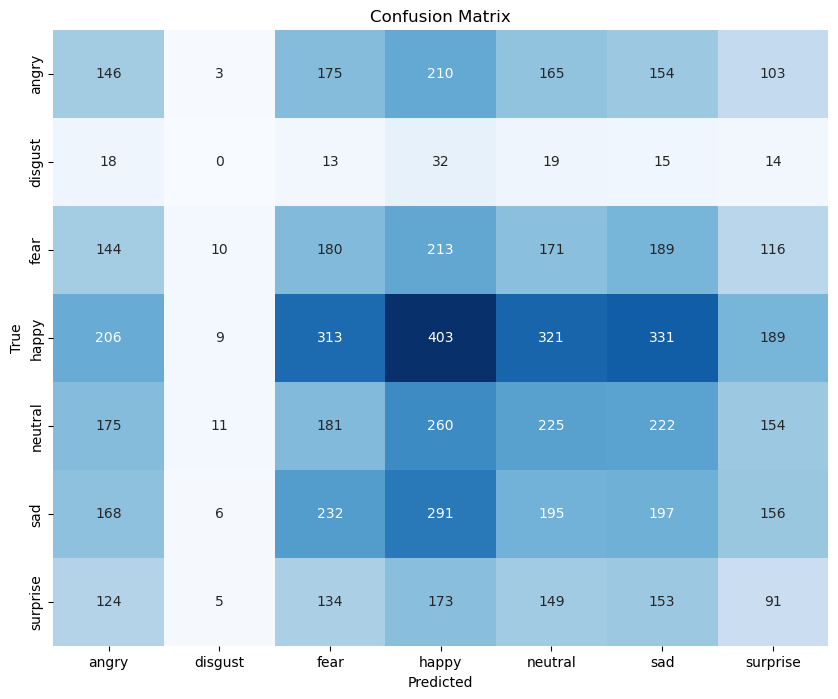

In [65]:
# Creates a confusion matrix of the true vs. predicted classes.
conf_matrix = confusion_matrix(y_true, y_pred)

# Plots the confusion matrix using seaborn, and matplotlib is used to
# display it.
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### References
- https://www.tensorflow.org/tutorials/images/cnn
- https://www.analyticsvidhya.com/blog/2021/01/image-classification-using-convolutional-neural-networks-a-step-by-step-guide/
- https://www.geeksforgeeks.org/emotion-detection-using-convolutional-neural-networks-cnns/
- https://medium.com/@birdortyedi_23820/deep-learning-lab-episode-3-fer2013-c38f2e052280#:~:text=fer2013%20is%20an%20open%2Dsource,competition%2C%20shortly%20before%20ICML%202013
- https://nupmanyu.medium.com/understanding-cnn-convolution-neural-network-b6eebab447f2
- https://www.baeldung.com/cs/batch-normalization-cnn